In [ ]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr

from patsy import dmatrix

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler

import math

def convert_float64(X):
    return X.astype(np.float64)

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 8927
az.style.use("arviz-darkgrid")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
st_pete_property_df = pd.read_csv('/content/drive/MyDrive/why_people_stay/zillow_parcel_census_coast_flood_st_pete.csv', index_col=0)

In [ ]:
st_pete_property_df.columns

Index(['zpid', 'streetAddress', 'zipcode', 'city', 'state', 'latitude',
       'longitude', 'price', 'bathrooms', 'bedrooms', 'livingArea',
       'YEAR_BUILT', 'EFFECTIVE_AGE', 'COOLING', 'HEATING', 'POOL', 'TENNIS',
       'CONTAMINATION_YN', 'EVAC_ZONE', 'WATERFRONT_YN', 'SEAWALL', 'geometry',
       'GEOID', 'hhinc_k', 'flood_risk', 'MC_std', 'dist2coast',
       'grocery_access'],
      dtype='object')

In [ ]:
st_pete_property_df['lg_price'] = np.log10(st_pete_property_df.price)
st_pete_property_df['dist2coast_km'] = st_pete_property_df['dist2coast']/1000

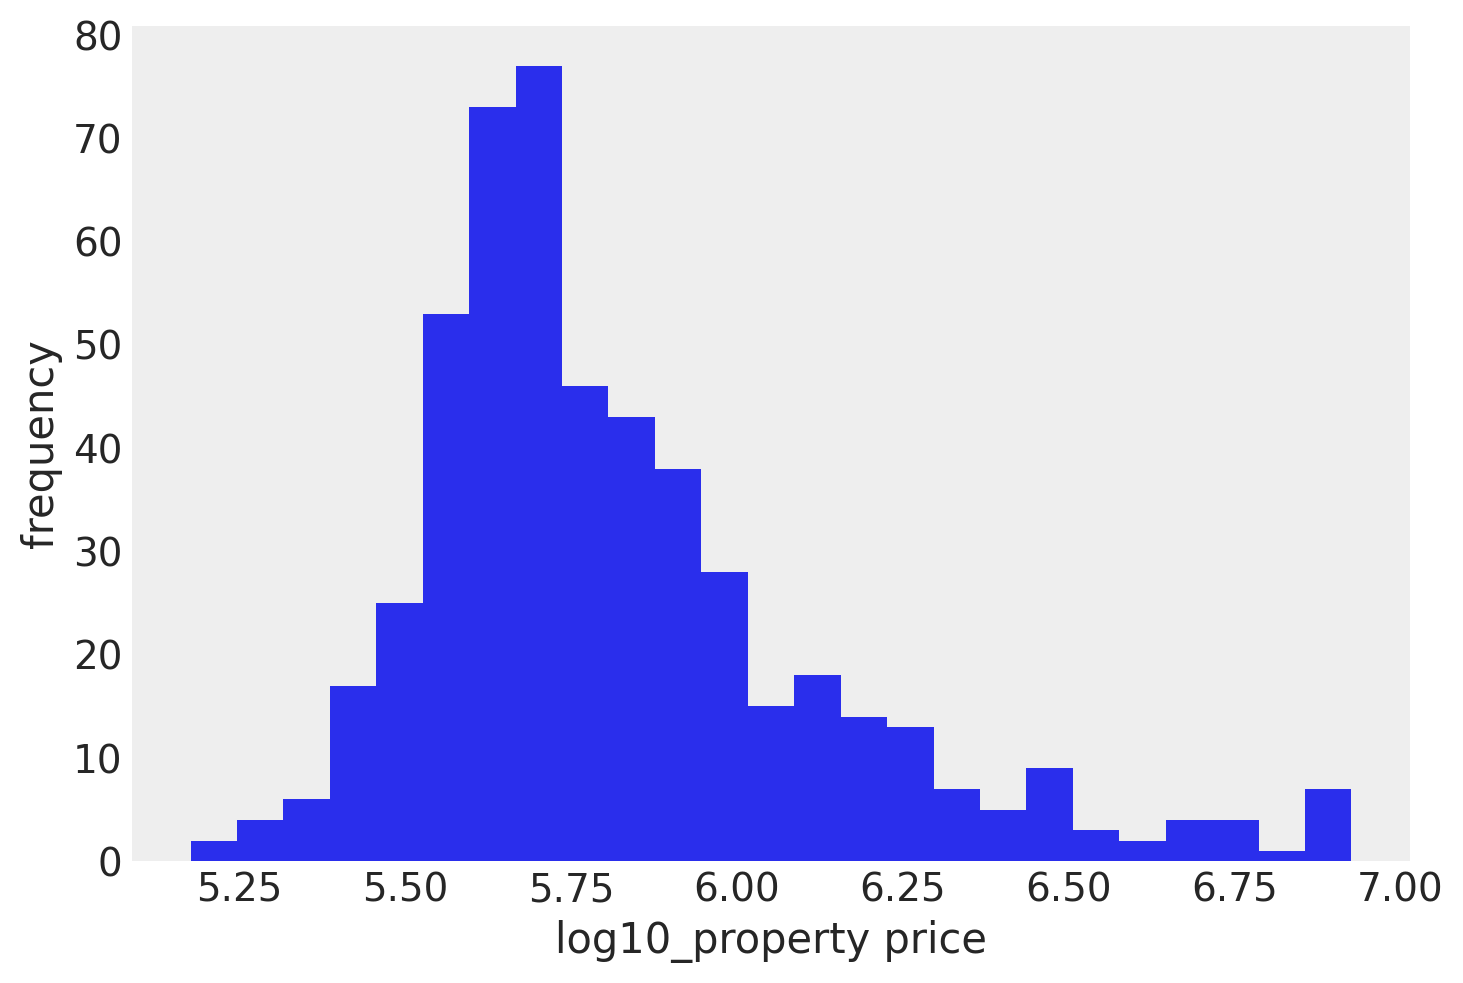

In [ ]:
st_pete_property_df.lg_price.hist(bins=25, grid=False)
plt.xlabel("log10_property price")
plt.ylabel("frequency");

In [ ]:
tract_idx, tracts = st_pete_property_df.GEOID.factorize()
st_pete_property_df['tract_idx'] = tract_idx

In [ ]:
# ['lg_price', 'bathrooms', 'livingArea', 'POOL', 'hhinc_k', 'flood_risk', 'dist2coast_km']
# ['lg_price', 'bathrooms', 'livingArea', 'POOL', 'EVAC_ZONE', 'hhinc_k', 'dist2coast_km']
st_pete_property_mod = st_pete_property_df[['lg_price', 'bathrooms', 'livingArea', 'POOL', 'EVAC_ZONE', 'hhinc_k', 'flood_risk', 'dist2coast_km','tract_idx']].dropna().reset_index(drop=True)

In [ ]:
numerical_columns = ['bathrooms', 'livingArea', 'hhinc_k', 'flood_risk', 'dist2coast_km']
numerical_pipeline = make_pipeline(
    FunctionTransformer(func=convert_float64, validate=False),
    StandardScaler()
)

categorical_columns = ['EVAC_ZONE', 'POOL']
categorical_pipeline = make_pipeline(
    OneHotEncoder(categories="auto"),
)

preprocessor = ColumnTransformer(
    [
        ("numerical_preprocessing", numerical_pipeline, numerical_columns),
        ("categorical_preprocessing", categorical_pipeline, categorical_columns),
    ],
)

In [ ]:
st_pete_property_mod.columns[1:-1]

Index(['bathrooms', 'livingArea', 'POOL', 'EVAC_ZONE', 'hhinc_k', 'flood_risk',
       'dist2coast_km'],
      dtype='object')

In [ ]:
X = st_pete_property_mod[st_pete_property_mod.columns[1:-1]].reset_index(drop=True)
Y = st_pete_property_mod[st_pete_property_mod.columns[0]].reset_index(drop=True)

In [ ]:
# Fit the preprocessor first
preprocessor.fit(X)

# Extract feature names for numerical columns
numerical_feature_names = numerical_columns

# Extract feature names for categorical columns using the OneHotEncoder step
categorical_feature_names = (
    preprocessor.named_transformers_['categorical_preprocessing']
    .named_steps['onehotencoder']
    .get_feature_names_out(categorical_columns)
)

# Combine both numerical and categorical feature names
all_feature_names = np.concatenate([numerical_feature_names, categorical_feature_names])

# Display the feature names
print("Feature Names After Transformation:")
print(all_feature_names)


Feature Names After Transformation:
['bathrooms' 'livingArea' 'hhinc_k' 'flood_risk' 'dist2coast_km'
 'EVAC_ZONE_A' 'EVAC_ZONE_B' 'EVAC_ZONE_C' 'EVAC_ZONE_D' 'EVAC_ZONE_E'
 'EVAC_ZONE_NON EVAC' 'POOL_N' 'POOL_Y']


In [ ]:
bathrooms = preprocessor.transform(X)[:,0]
livingArea = preprocessor.transform(X)[:,1]
hhinc_k = preprocessor.transform(X)[:,2]
flood_risk = preprocessor.transform(X)[:,3]
dist2coast_km = preprocessor.transform(X)[:,4]
ZONE_A = preprocessor.transform(X)[:,5]
ZONE_B = preprocessor.transform(X)[:,6]
ZONE_C = preprocessor.transform(X)[:,7]
ZONE_D = preprocessor.transform(X)[:,8]
ZONE_E = preprocessor.transform(X)[:,9]
POOL = preprocessor.transform(X)[:,12]
tract_idx = st_pete_property_mod.tract_idx.values

### spline regression, sampling needs investigation

In [ ]:
num_knots = 5
knot_list = np.quantile(flood_risk, np.linspace(0, 1, num_knots))
knot_list

array([-0.7838397 , -0.78114287, -0.65025424,  1.11439334,  1.75916418])

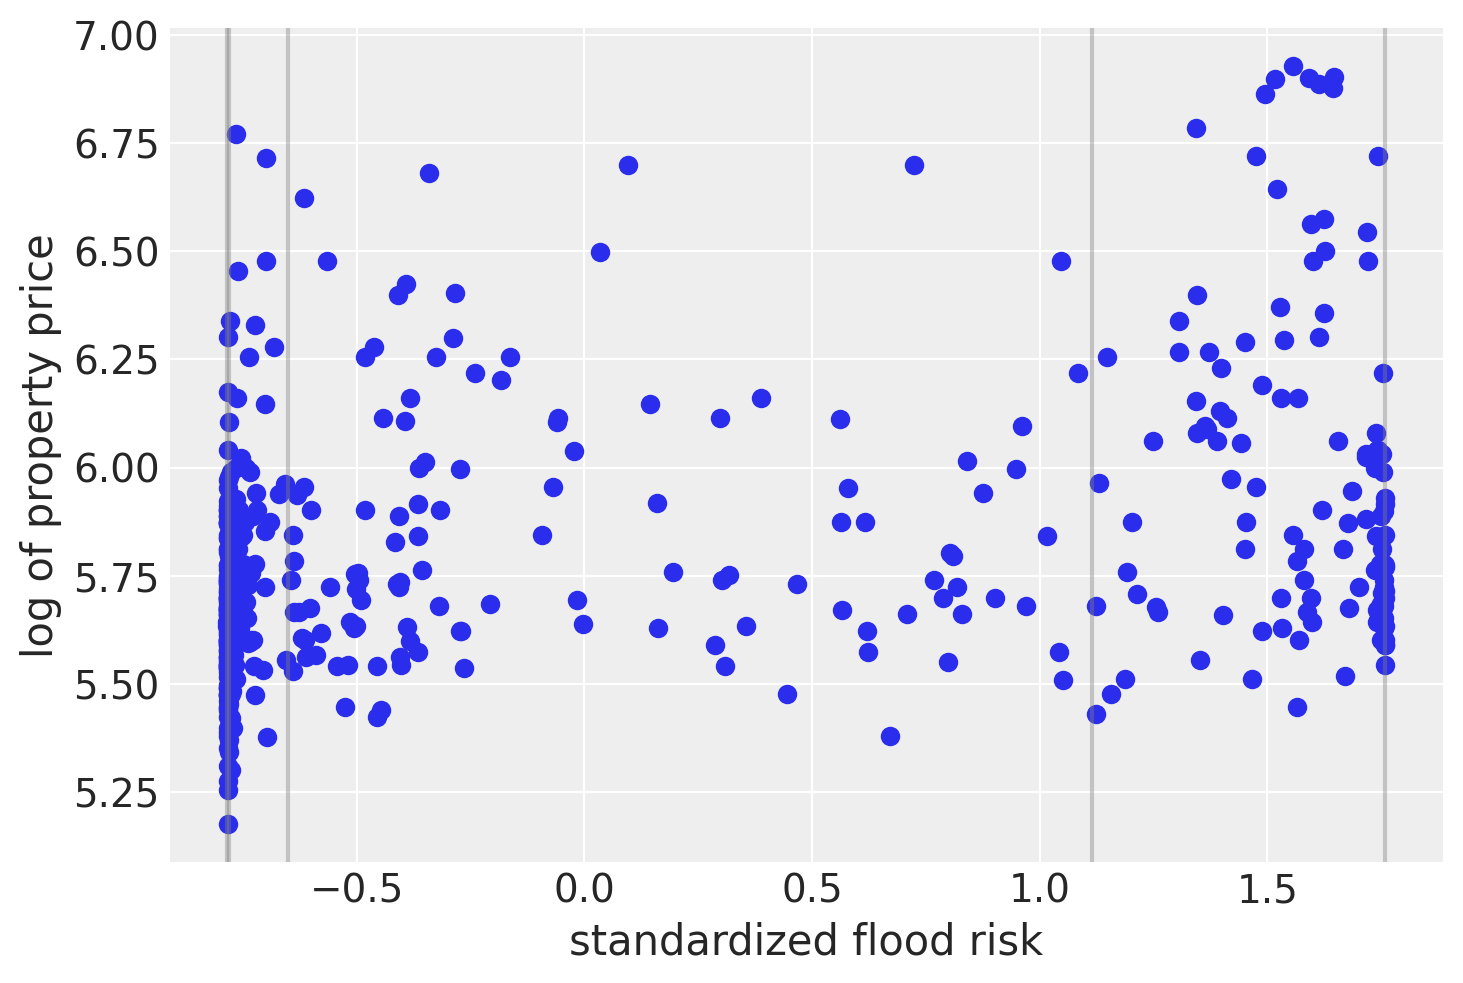

In [ ]:
# Create a scatter plot
plt.scatter(flood_risk, Y)

# Add labels and title
plt.xlabel("standardized flood risk")
plt.ylabel("log of property price")

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

In [ ]:
B = dmatrix(
    "bs(flood_risk, knots=knots, degree=3, include_intercept=True) - 1",
    {"flood_risk": flood_risk, "knots": knot_list[1:-1]},
)
B

DesignMatrix with shape (478, 7)
  Columns:
    ['bs(flood_risk, knots=knots, degree=3, include_intercept=True)[0]',
     'bs(flood_risk, knots=knots, degree=3, include_intercept=True)[1]',
     'bs(flood_risk, knots=knots, degree=3, include_intercept=True)[2]',
     'bs(flood_risk, knots=knots, degree=3, include_intercept=True)[3]',
     'bs(flood_risk, knots=knots, degree=3, include_intercept=True)[4]',
     'bs(flood_risk, knots=knots, degree=3, include_intercept=True)[5]',
     'bs(flood_risk, knots=knots, degree=3, include_intercept=True)[6]']
  Terms:
    'bs(flood_risk, knots=knots, degree=3, include_intercept=True)' (columns 0:7)
  (to view full data, use np.asarray(this_obj))

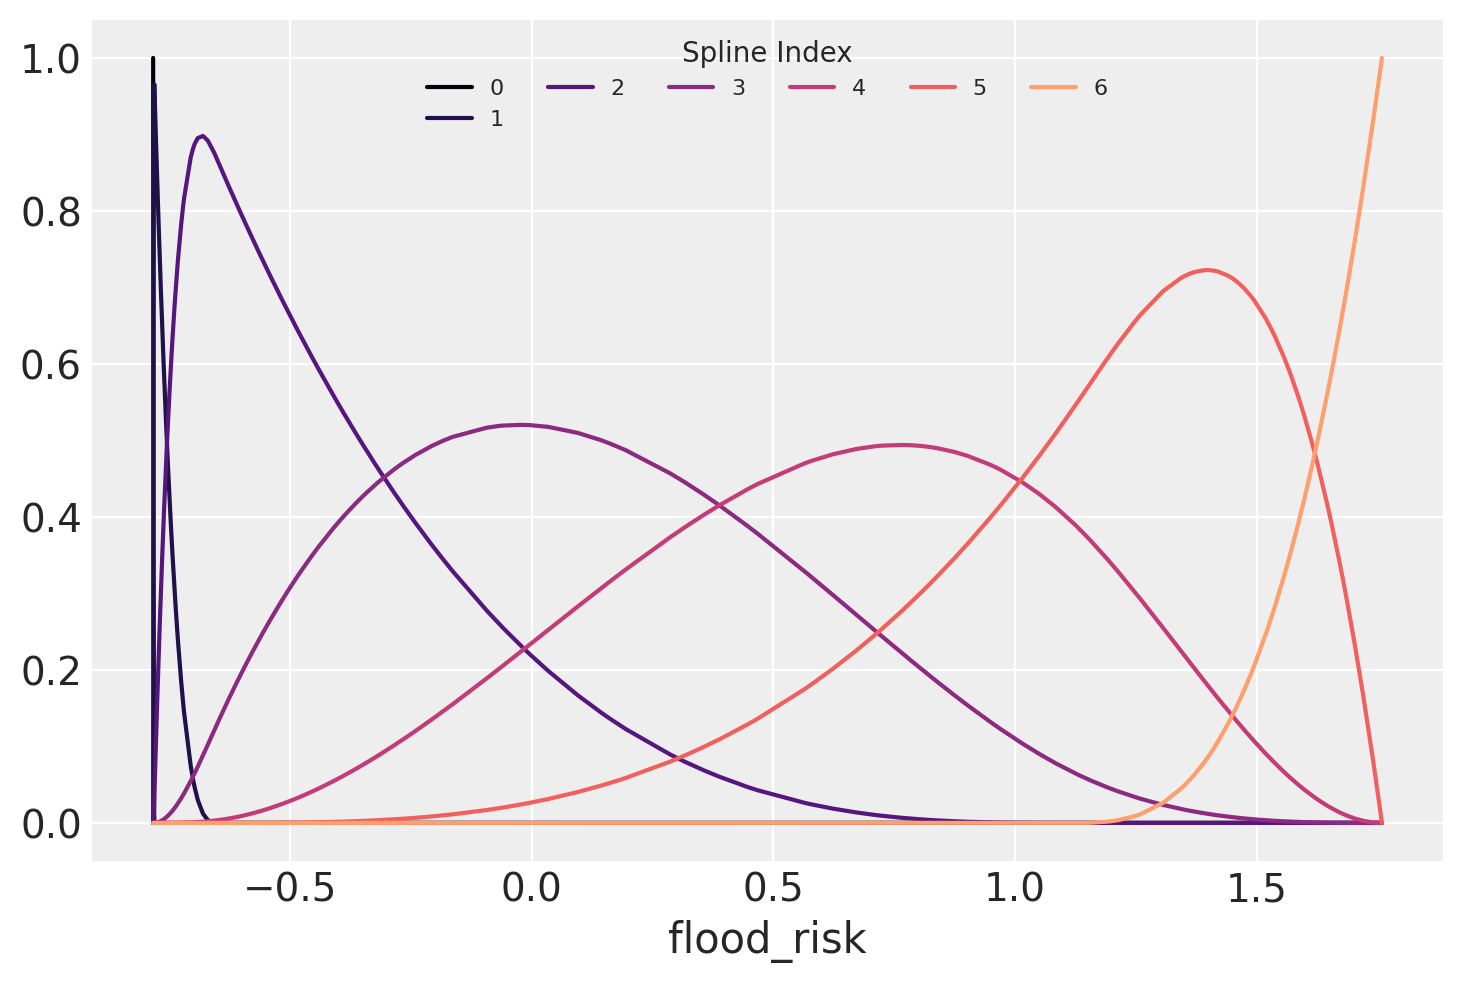

In [ ]:
spline_df = (
    pd.DataFrame(B)
    .assign(flood_risk=flood_risk)
    .melt("flood_risk", var_name="spline_i", value_name="value")
    .sort_values("flood_risk")
    .reset_index(drop=True)
)

color = plt.cm.magma(np.linspace(0, 0.80, len(spline_df.spline_i.unique())))

fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("flood_risk", "value", c=c, ax=plt.gca(), label=i)
plt.legend(title="Spline Index", loc="upper center", fontsize=8, ncol=6);

In [ ]:
COORDS = {"splines": np.arange(B.shape[1])}
with pm.Model(coords=COORDS) as spline_model:
    sigma = pm.HalfCauchy("sigma", beta=10)
    intercept = pm.Normal("Intercept", 0, sigma=1)
    bathrooms_slope = pm.Normal("bathrooms_slope", 0, sigma=1)
    livingArea_slope = pm.Normal("livingArea_slope", 0, sigma=1)
    hhinc_k_slope = pm.Normal("hhinc_k_slope", 0, sigma=1)

    # Non-centered parameterization, but does not seem helpful to get distinguished "w"
    mu_w = pm.Normal("mu_w", mu=0.0, sigma=3.0)
    sigma_w = pm.Exponential("sigma_w", 5)
    z_w = pm.Normal("z_w", mu=0, sigma=1, size=B.shape[1], dims="splines")
    w = pm.Deterministic("w", mu_w + z_w * sigma_w, dims="splines")

    dist2coast_km_slope = pm.Normal("dist2coast_km_slope", 0, sigma=1)
    ZONE_A_slope = pm.Normal("ZONE_A_slope", 0, sigma=1)
    ZONE_B_slope = pm.Normal("ZONE_B_slope", 0, sigma=1)
    ZONE_C_slope = pm.Normal("ZONE_C_slope", 0, sigma=1)
    ZONE_D_slope = pm.Normal("ZONE_D_slope", 0, sigma=1)
    ZONE_E_slope = pm.Normal("ZONE_E_slope", 0, sigma=1)
    POOL_slope = pm.Normal("POOL_slope", 0, sigma=1)

    mu = pm.Deterministic("mu", intercept + \
                          bathrooms_slope*bathrooms + \
                          livingArea_slope*livingArea + \
                          hhinc_k_slope*hhinc_k + \
                          pm.math.dot(np.asarray(B, order="F"), w.T) + \
                          dist2coast_km_slope*dist2coast_km + \
                          ZONE_A_slope*ZONE_A + \
                          ZONE_B_slope*ZONE_B + \
                          ZONE_C_slope*ZONE_C + \
                          ZONE_D_slope*ZONE_D + \
                          ZONE_E_slope*ZONE_E + \
                          POOL_slope*POOL)

    likelihood = pm.LogNormal("y", mu=mu, sigma=sigma, observed=Y)

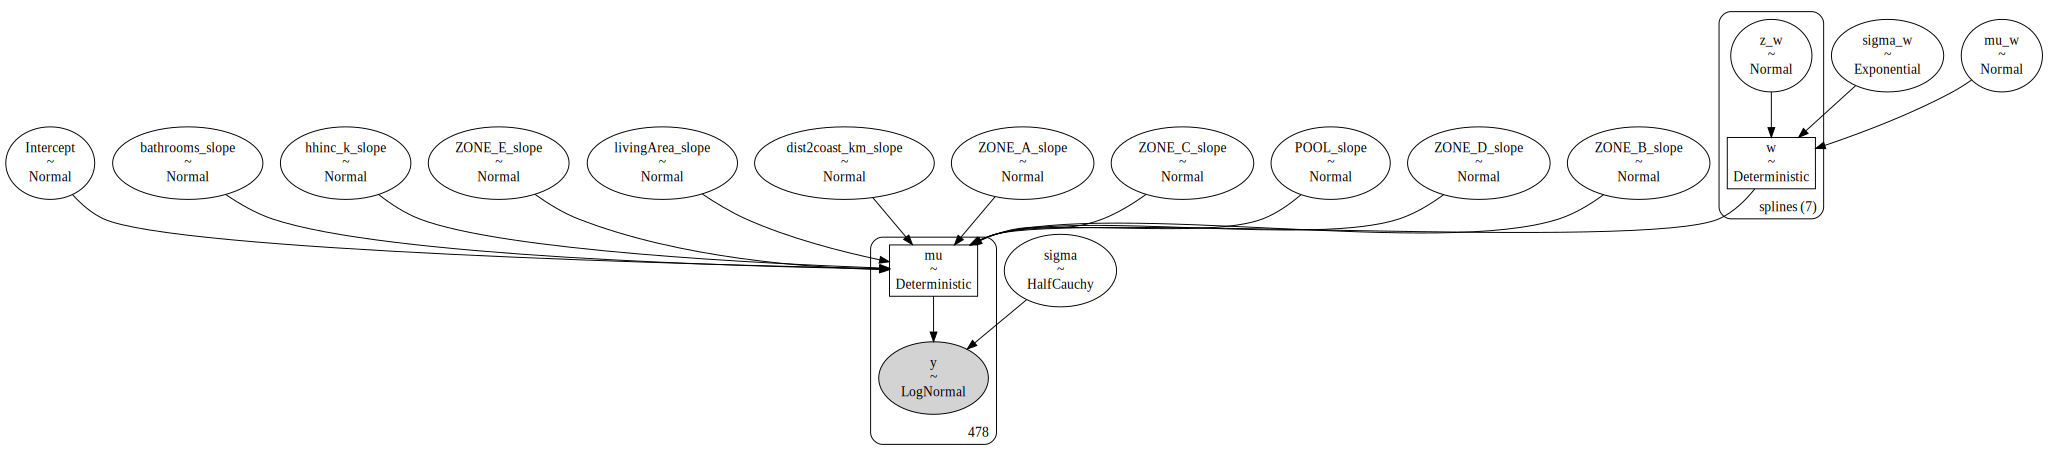

In [ ]:
pm.model_to_graphviz(spline_model)

In [ ]:
with spline_model:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

Output()

Output()

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

In [ ]:
idata.to_netcdf('/content/drive/MyDrive/why_people_stay/spline_noncenter01182025.nc')

'/content/drive/MyDrive/why_people_stay/spline_noncenter01182025.nc'

In [ ]:
idata_saved = az.from_netcdf('/content/drive/MyDrive/why_people_stay/spline_noncenter01182025.nc')

In [ ]:
az.summary(idata_saved, var_names=["w"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],1.668,1.006,-0.187,3.578,0.069,0.049,217.0,512.0,1.01
w[1],1.662,1.006,-0.196,3.571,0.069,0.049,217.0,508.0,1.01
w[2],1.673,1.006,-0.022,3.752,0.069,0.049,217.0,516.0,1.01
w[3],1.681,1.006,-0.167,3.608,0.068,0.048,217.0,511.0,1.01
w[4],1.666,1.007,-0.173,3.597,0.069,0.049,216.0,509.0,1.01
w[5],1.687,1.006,-0.007,3.767,0.068,0.048,217.0,511.0,1.01
w[6],1.643,1.006,-0.047,3.724,0.069,0.049,217.0,510.0,1.01


In [ ]:
az.summary(idata_saved, var_names=["bathrooms_slope","livingArea_slope","hhinc_k_slope","dist2coast_km_slope","POOL_slope"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bathrooms_slope,0.008,0.002,0.004,0.013,0.0,0.0,153.0,287.0,1.04
livingArea_slope,0.027,0.002,0.023,0.032,0.0,0.0,143.0,251.0,1.04
hhinc_k_slope,0.012,0.002,0.009,0.015,0.0,0.0,397.0,696.0,1.01
dist2coast_km_slope,-0.009,0.002,-0.012,-0.005,0.0,0.0,190.0,527.0,1.02
POOL_slope,0.013,0.002,0.009,0.018,0.0,0.0,367.0,699.0,1.01


In [ ]:
az.summary(idata_saved, var_names=["Intercept","sigma","mu"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.096,1.006,-1.814,1.957,0.069,0.049,217.0,512.0,1.01
sigma,0.022,0.001,0.021,0.024,0.000,0.000,290.0,629.0,1.01
mu[0],1.718,0.003,1.713,1.723,0.000,0.000,273.0,783.0,1.01
mu[1],1.795,0.003,1.789,1.802,0.000,0.000,401.0,1460.0,1.00
mu[2],1.720,0.004,1.713,1.728,0.000,0.000,405.0,889.0,1.01
...,...,...,...,...,...,...,...,...,...
mu[473],1.934,0.007,1.922,1.946,0.000,0.000,354.0,974.0,1.01
mu[474],1.780,0.004,1.773,1.787,0.000,0.000,689.0,1623.0,1.00
mu[475],1.764,0.004,1.758,1.771,0.000,0.000,1586.0,3430.0,1.00
mu[476],1.828,0.005,1.819,1.837,0.000,0.000,623.0,1259.0,1.01


In [ ]:
az.summary(idata_saved, var_names=["ZONE_A_slope","ZONE_B_slope","ZONE_C_slope","ZONE_D_slope","ZONE_E_slope"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ZONE_A_slope,-0.012,0.006,-0.023,-0.001,0.001,0.0,125.0,243.0,1.04
ZONE_B_slope,-0.024,0.006,-0.035,-0.013,0.000,0.0,148.0,349.0,1.04
ZONE_C_slope,-0.015,0.006,-0.026,-0.003,0.000,0.0,170.0,454.0,1.03
ZONE_D_slope,-0.012,0.005,-0.021,-0.002,0.000,0.0,134.0,284.0,1.03
ZONE_E_slope,-0.013,0.005,-0.022,-0.005,0.000,0.0,152.0,256.0,1.03


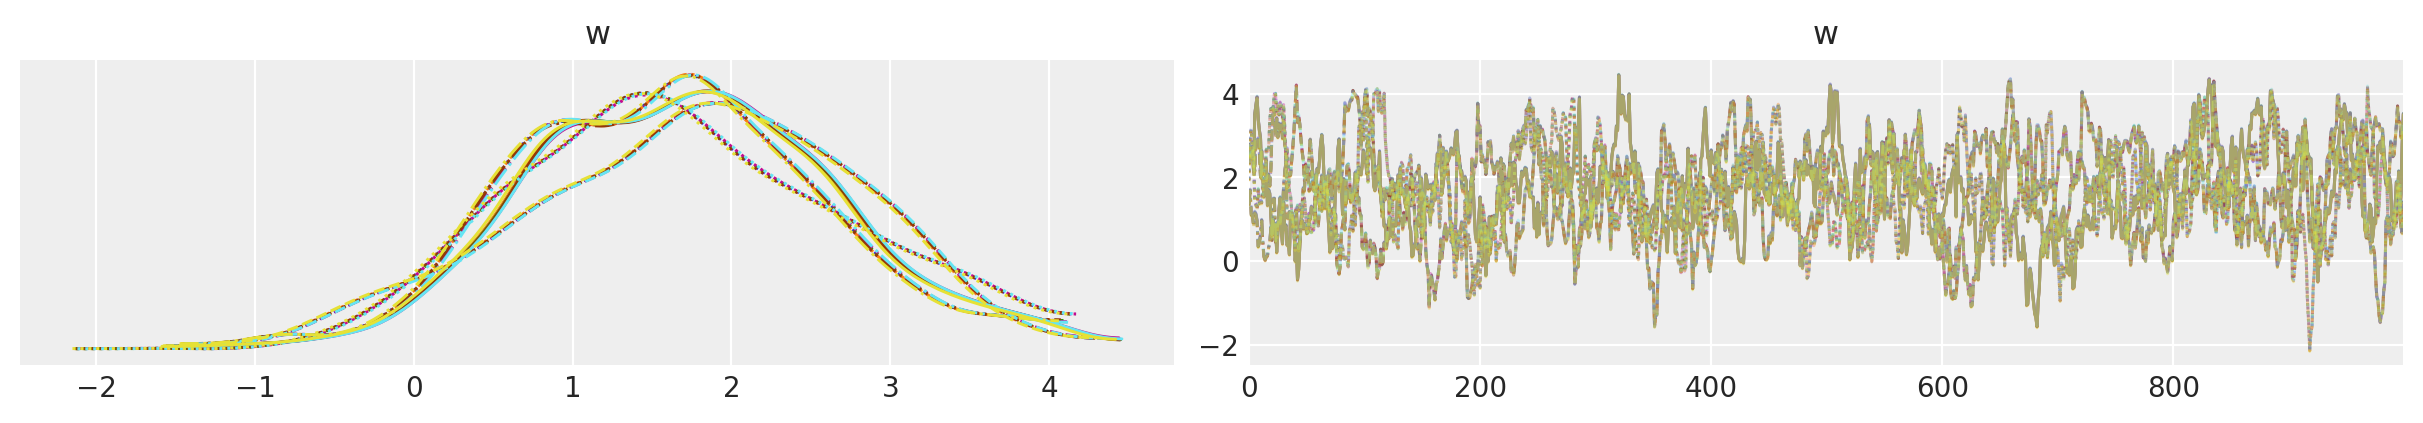

In [ ]:
az.plot_trace(idata, var_names=["w"]);

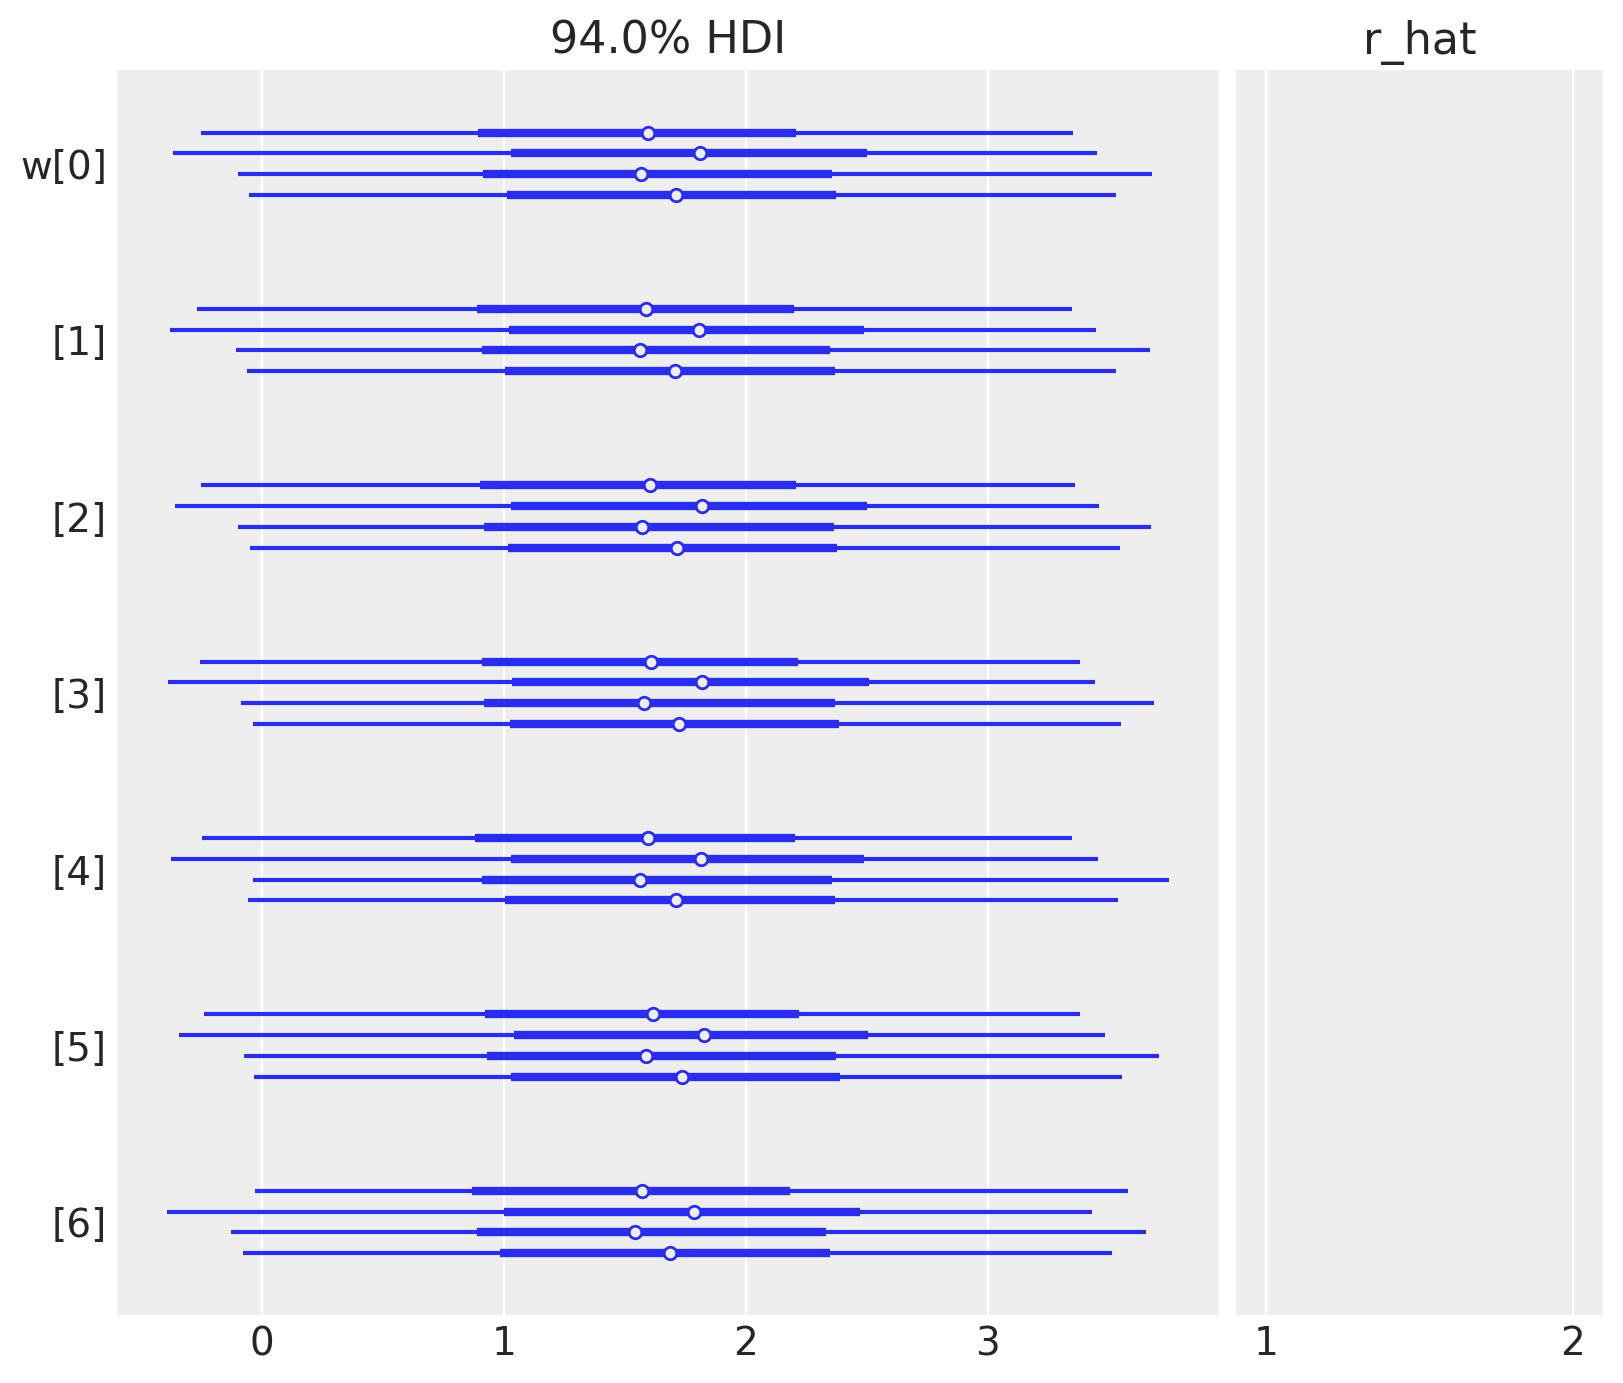

In [ ]:
az.plot_forest(idata, var_names=["w"], combined=False, r_hat=True);

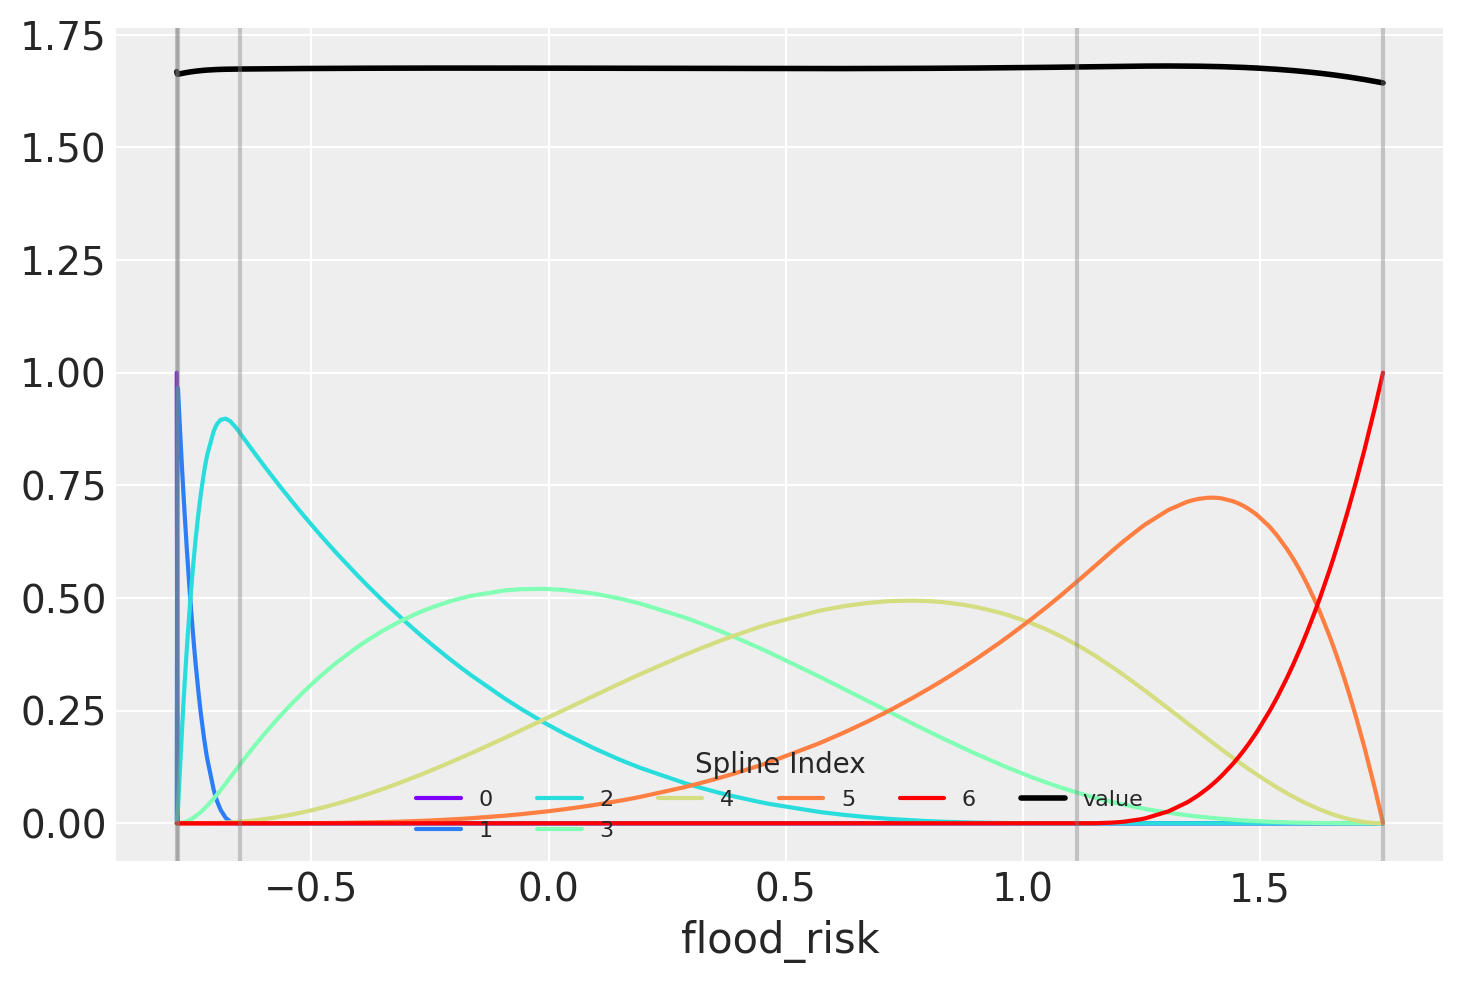

In [ ]:
wp = idata.posterior["w"].mean(("chain", "draw")).values

spline_df = (
    pd.DataFrame(B)
    .assign(flood_risk=flood_risk)
    .melt("flood_risk", var_name="spline_i", value_name="value")
    .sort_values("flood_risk")
    .reset_index(drop=True)
)

spline_df_merged = (
    pd.DataFrame(np.dot(B, wp.T))
    .assign(flood_risk=flood_risk)
    .melt("flood_risk", var_name="spline_i", value_name="value")
    .sort_values("flood_risk")
    .reset_index(drop=True)
)


color = plt.cm.rainbow(np.linspace(0, 1, len(spline_df.spline_i.unique())))
fig = plt.figure()
for i, c in enumerate(color):
    subset = spline_df.query(f"spline_i == {i}")
    subset.plot("flood_risk", "value", c=c, ax=plt.gca(), label=i)
spline_df_merged.plot("flood_risk", "value", c="black", lw=2, ax=plt.gca())
plt.legend(title="Spline Index", loc="lower center", fontsize=8, ncol=6)

for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

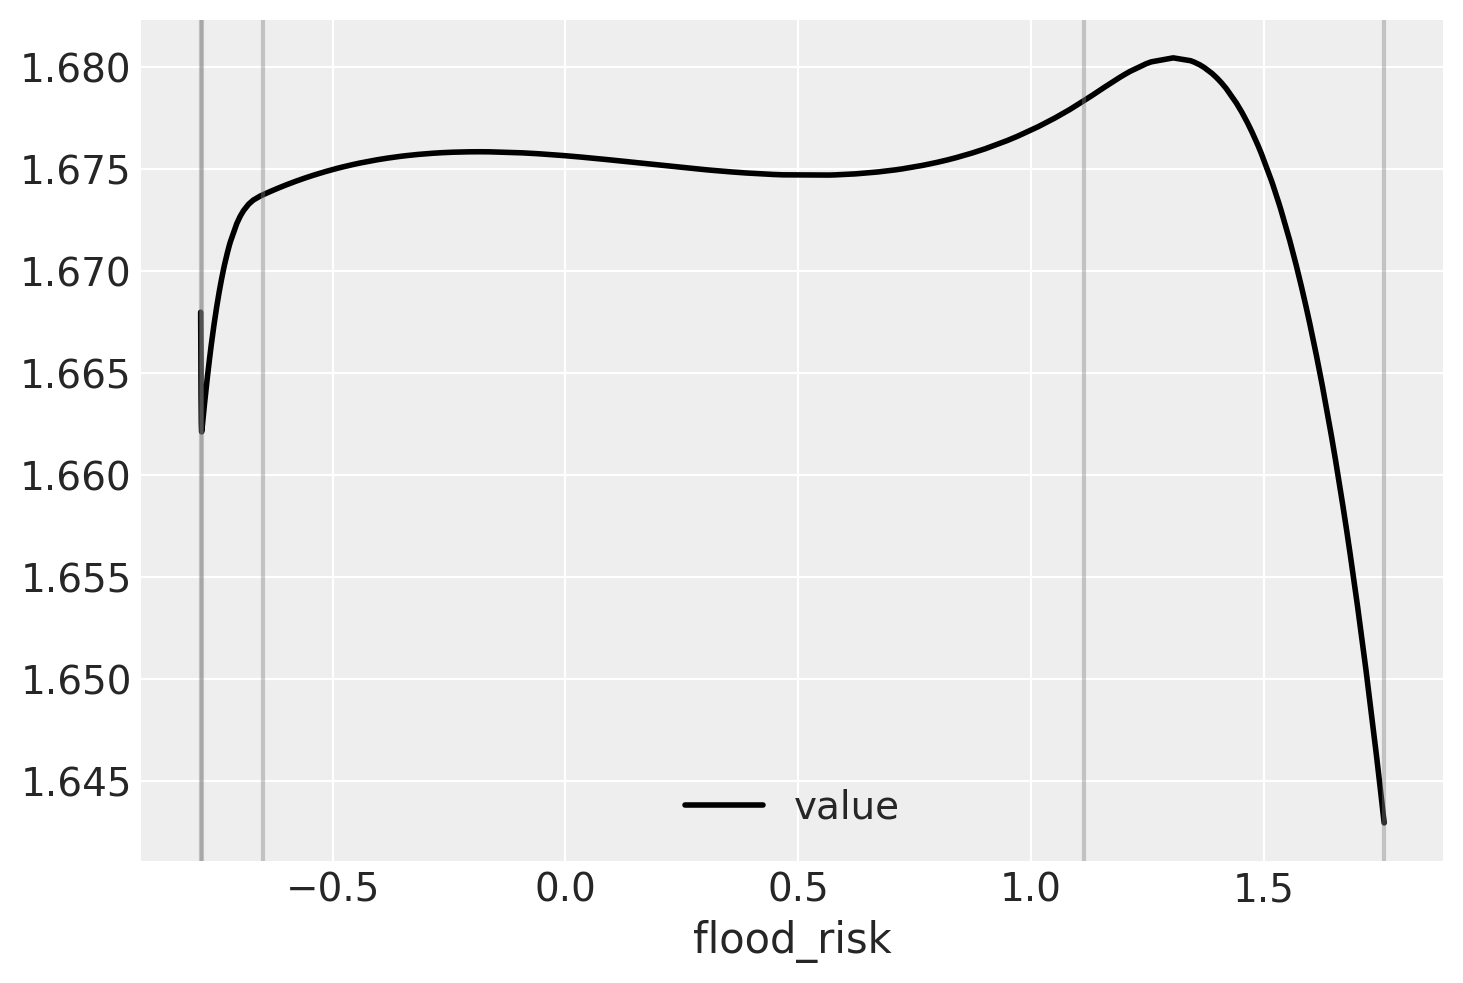

In [ ]:
spline_df_merged.plot("flood_risk", "value", c="black", lw=2, ax=plt.gca())
for knot in knot_list:
    plt.gca().axvline(knot, color="grey", alpha=0.4);

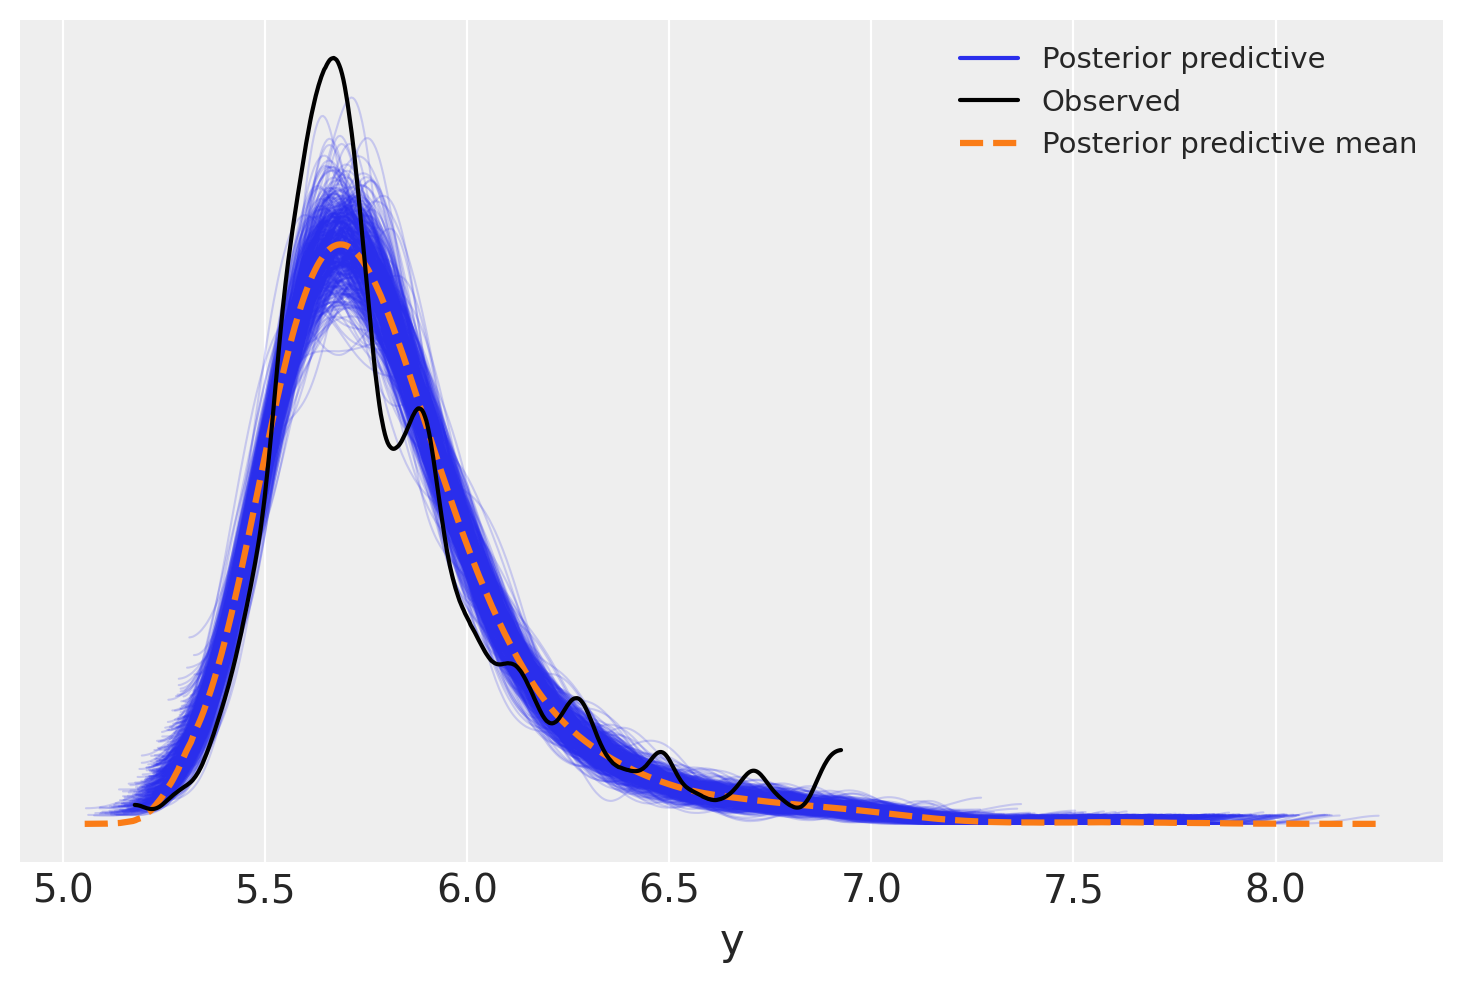

In [ ]:
az.plot_ppc(idata, num_pp_samples=500);

In [ ]:
# post_pred = az.summary(idata, var_names=["mu"]).reset_index(drop=True)
st_pete_property_mod_post = st_pete_property_mod.copy().reset_index(drop=True)
st_pete_property_mod_post["pred_mean"] = np.mean(idata.posterior_predictive['y'], axis=(0, 1))

In [ ]:
st_pete_property_mod_post = st_pete_property_mod_post.sort_values("flood_risk")

<Axes: title={'center': 'Property Price data with posterior predictions'}, xlabel='flood_risk', ylabel='log property price'>

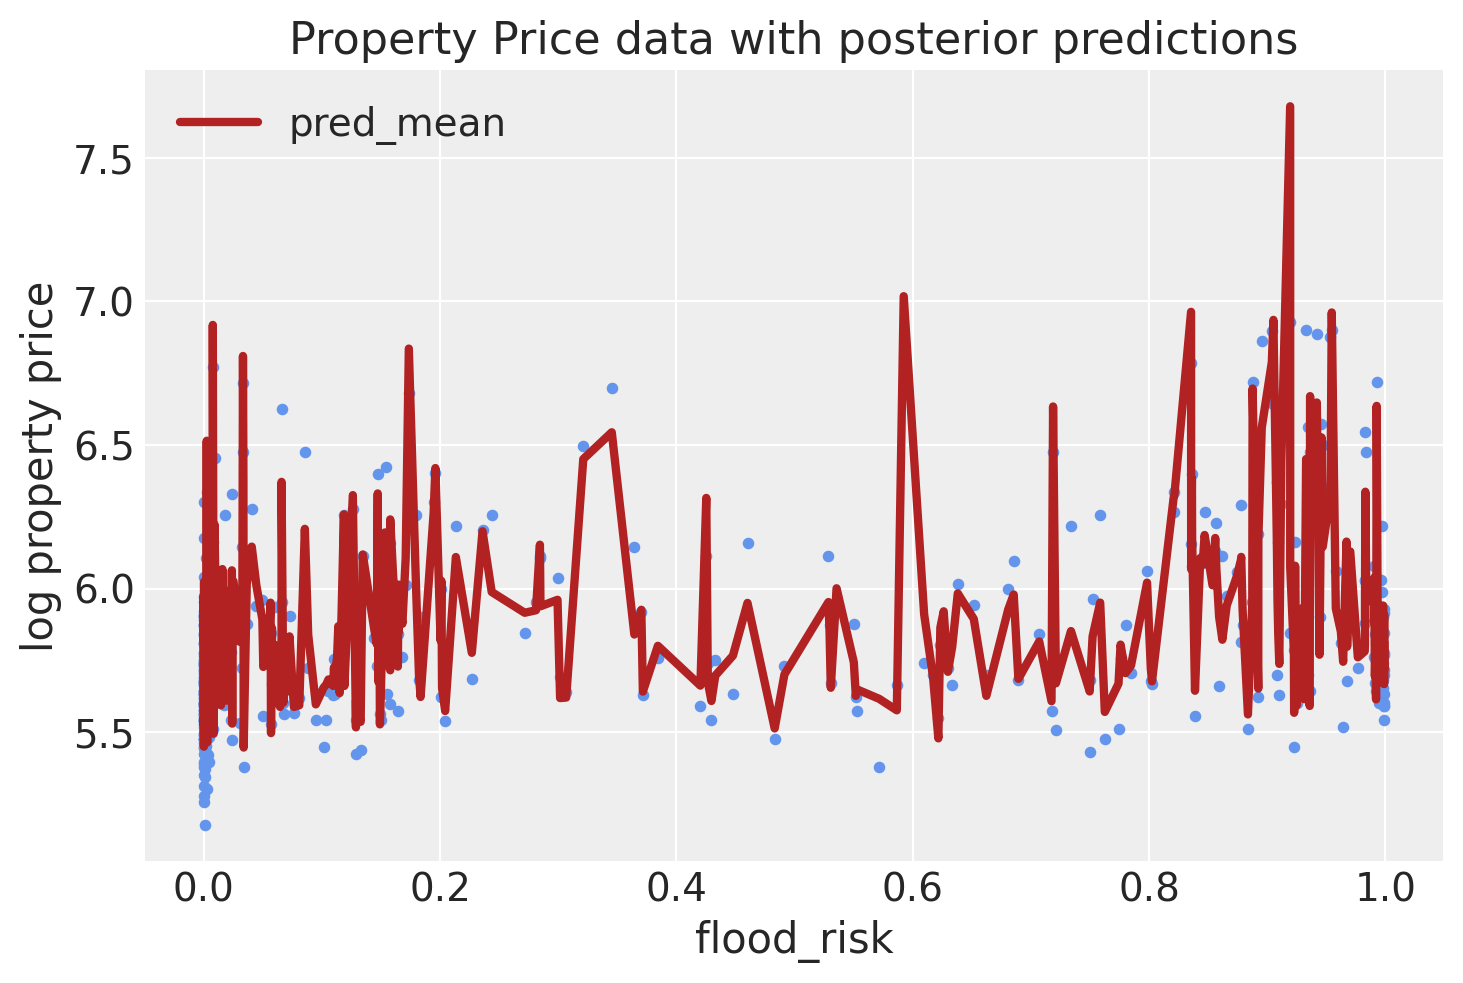

In [ ]:
st_pete_property_mod.plot.scatter(
    "flood_risk",
    "lg_price",
    color="cornflowerblue",
    s=10,
    title="Property Price data with posterior predictions",
    ylabel="log property price",
)
# for knot in knot_list:
#     plt.gca().axvline(knot, color="grey", alpha=0.4)

st_pete_property_mod_post.plot("flood_risk", "pred_mean", ax=plt.gca(), lw=3, color="firebrick")


### varing slopes on flood risk

In [ ]:
coords = {"tract": tracts}
with pm.Model(coords=coords) as varying_intercept_slope:

    # flood_risk = pm.MutableData("flood_risk", flood_risk, dims="obs_id")
    # tract_idx = pm.MutableData("tract_idx", tract_idx, dims="obs_id")

    mu_a = pm.Normal("mu_a", mu=0.0, sigma=1.0)
    sigma_a = pm.Exponential("sigma_a", 1)


    alpha = pm.Normal("alpha", mu=mu_a, sigma=sigma_a, dims="tract")

    bathrooms_slope = pm.Normal("bathrooms_slope", 0, sigma=1)
    livingArea_slope = pm.Normal("livingArea_slope", 0, sigma=1)
    hhinc_k_slope = pm.Normal("hhinc_k_slope", 0, sigma=1)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 1)


    flood_risk_beta = pm.Normal("flood_risk_beta", mu=mu_b, sigma=sigma_b, dims="tract")

    dist2coast_km_slope = pm.Normal("dist2coast_km_slope", 0, sigma=1)
    ZONE_A_slope = pm.Normal("ZONE_A_slope", 0, sigma=1)
    ZONE_B_slope = pm.Normal("ZONE_B_slope", 0, sigma=1)
    ZONE_C_slope = pm.Normal("ZONE_C_slope", 0, sigma=1)
    ZONE_D_slope = pm.Normal("ZONE_D_slope", 0, sigma=1)
    ZONE_E_slope = pm.Normal("ZONE_E_slope", 0, sigma=1)
    POOL_slope = pm.Normal("POOL_slope", 0, sigma=1)

    sigma_y = pm.Exponential("sigma_y", 1)

    y_hat = alpha[tract_idx] + \
            bathrooms_slope*bathrooms + \
            livingArea_slope*livingArea + \
            hhinc_k_slope*hhinc_k + \
            flood_risk_beta[tract_idx]*flood_risk + \
            dist2coast_km_slope*dist2coast_km + \
            ZONE_A_slope*ZONE_A + \
            ZONE_B_slope*ZONE_B + \
            ZONE_C_slope*ZONE_C + \
            ZONE_D_slope*ZONE_D + \
            ZONE_E_slope*ZONE_E + \
            POOL_slope*POOL



    likelihood = pm.LogNormal("y", mu=y_hat, sigma=sigma_y, observed=Y)

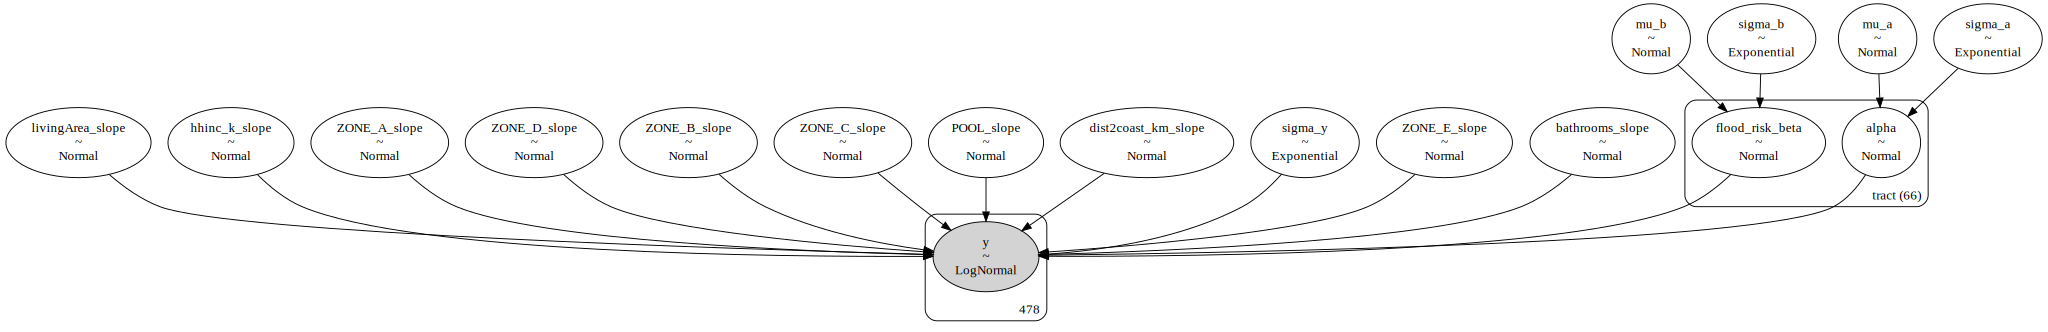

In [ ]:
pm.model_to_graphviz(varying_intercept_slope)

In [ ]:
with varying_intercept_slope:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

In [ ]:
prior_checks

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

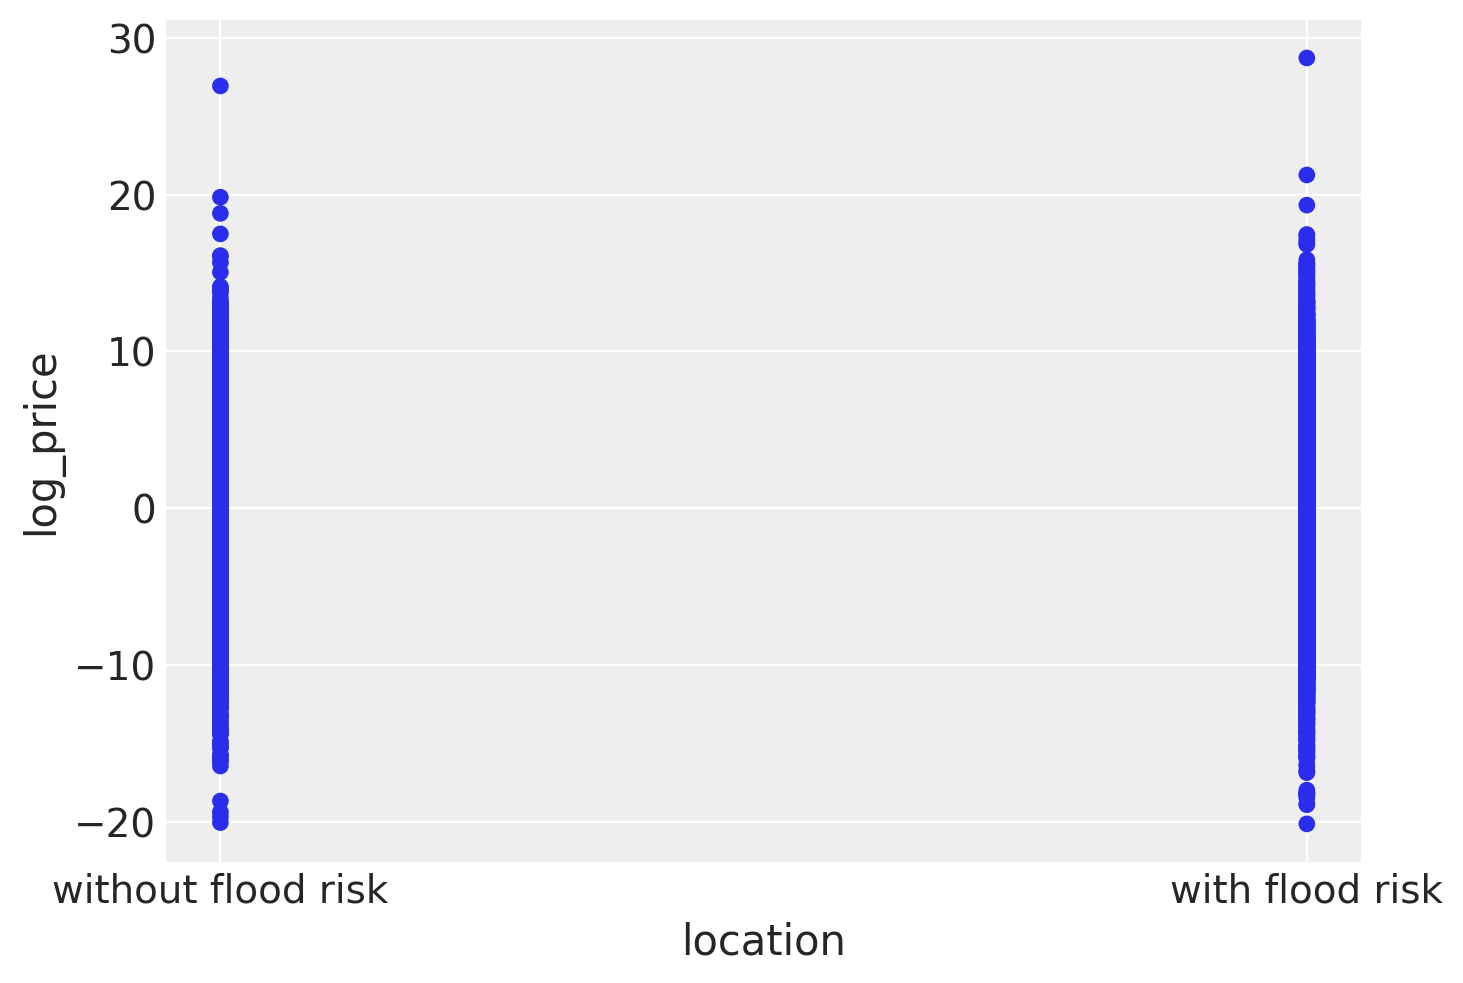

In [ ]:
prior = prior_checks.prior.squeeze(drop=True)

xr.concat((prior["alpha"] + prior.POOL_slope + prior.ZONE_A_slope + prior.ZONE_B_slope + prior.ZONE_C_slope + prior.ZONE_D_slope + prior.ZONE_E_slope +\
           prior.bathrooms_slope + prior.dist2coast_km_slope + prior.hhinc_k_slope + prior.livingArea_slope,

           prior["alpha"] + prior.POOL_slope + prior.ZONE_A_slope + prior.ZONE_B_slope + prior.ZONE_C_slope + prior.ZONE_D_slope + prior.ZONE_E_slope +\
           prior.bathrooms_slope + prior.dist2coast_km_slope + prior.hhinc_k_slope + prior.livingArea_slope+ prior["flood_risk_beta"]), dim="location")\
          .rename("log_price").assign_coords(location=["without flood risk", "with flood risk"])\
          .plot.scatter(x="location", y="log_price", edgecolors="none");

In [ ]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Output()

Output()

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [ ]:
varying_intercept_slope_trace.to_netcdf('/content/drive/MyDrive/why_people_stay/varying_slope01292025.nc')

'/content/drive/MyDrive/why_people_stay/varying_slope01292025.nc'

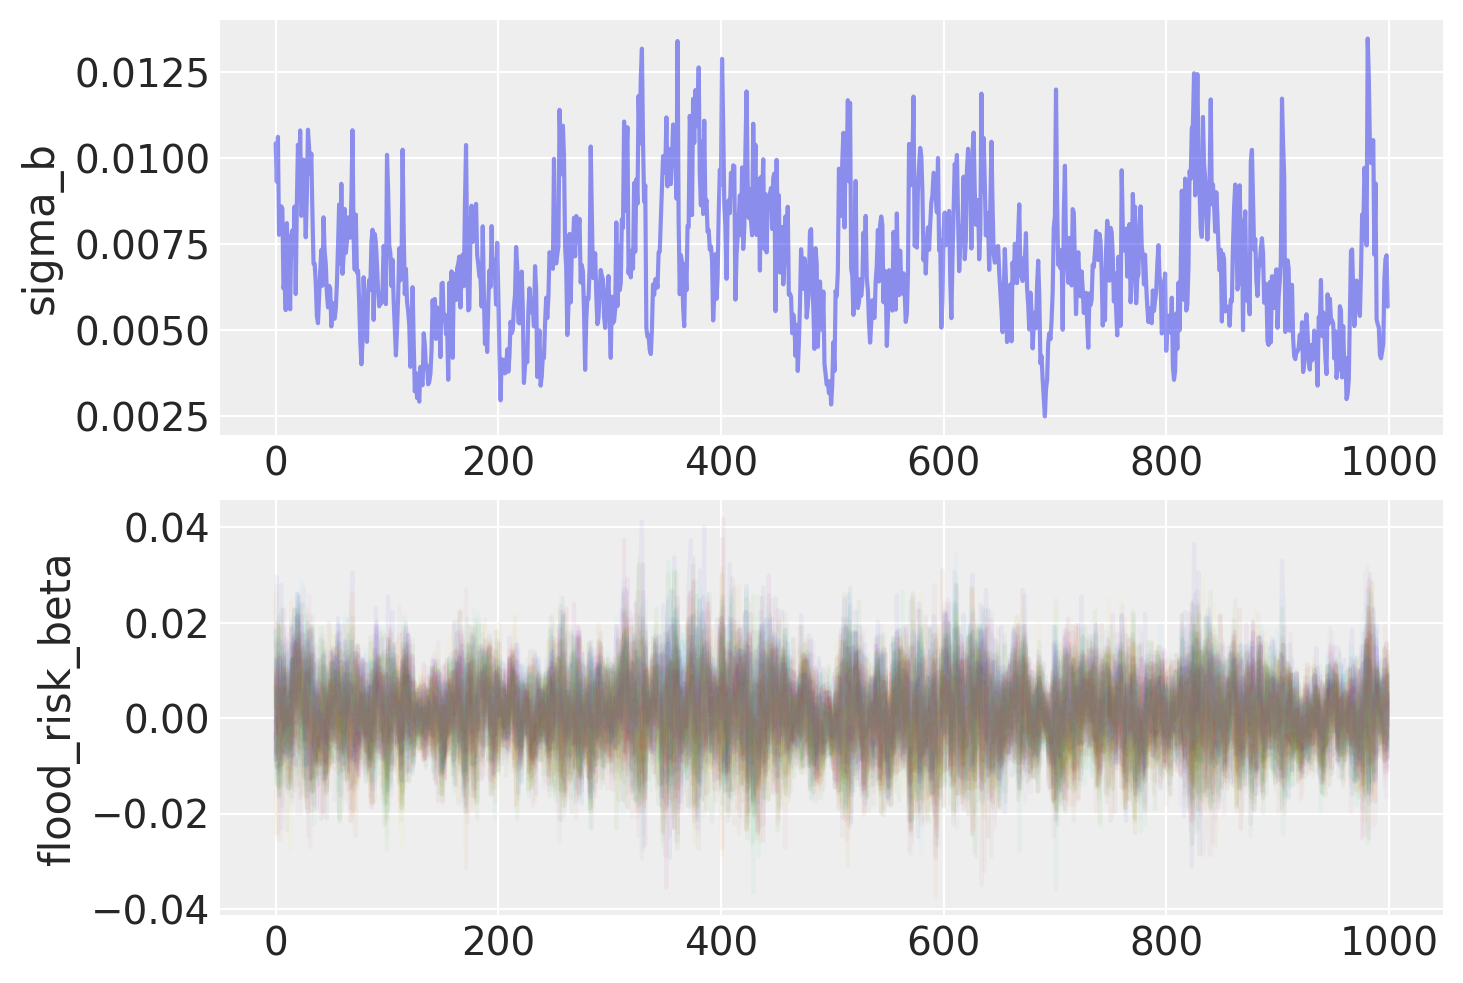

In [ ]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["sigma_b"], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["flood_risk_beta"], alpha=0.05)
axs[1].set(ylabel="flood_risk_beta");

In [ ]:
az.summary(varying_intercept_slope_trace, var_names=["bathrooms_slope","livingArea_slope","hhinc_k_slope","dist2coast_km_slope","POOL_slope"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bathrooms_slope,0.007,0.002,0.003,0.011,0.0,0.0,1010.0,1162.0,1.01
livingArea_slope,0.025,0.002,0.021,0.029,0.0,0.0,1181.0,998.0,1.00
hhinc_k_slope,0.014,0.003,0.008,0.018,0.0,0.0,322.0,769.0,1.01
dist2coast_km_slope,-0.010,0.002,-0.014,-0.005,0.0,0.0,463.0,712.0,1.02
POOL_slope,0.013,0.002,0.009,0.018,0.0,0.0,2015.0,1217.0,1.00


In [ ]:
az.summary(varying_intercept_slope_trace, var_names=["ZONE_A_slope","ZONE_B_slope","ZONE_C_slope","ZONE_D_slope","ZONE_E_slope"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ZONE_A_slope,-0.004,0.006,-0.016,0.007,0.001,0.001,50.0,390.0,1.05
ZONE_B_slope,-0.010,0.006,-0.022,0.001,0.000,0.000,184.0,491.0,1.02
ZONE_C_slope,-0.011,0.006,-0.021,0.001,0.000,0.000,240.0,727.0,1.02
ZONE_D_slope,-0.007,0.005,-0.017,0.003,0.001,0.000,62.0,574.0,1.04
ZONE_E_slope,-0.010,0.005,-0.020,-0.000,0.000,0.000,266.0,988.0,1.03


In [ ]:
az.summary(varying_intercept_slope_trace, var_names="flood_risk_beta")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
flood_risk_beta[12103020800],0.007,0.008,-0.007,0.023,0.0,0.0,408.0,645.0,1.0
flood_risk_beta[12103023300],-0.002,0.007,-0.015,0.011,0.0,0.0,1024.0,1307.0,1.0
flood_risk_beta[12103020109],0.002,0.007,-0.011,0.015,0.0,0.0,1321.0,1121.0,1.0
flood_risk_beta[12103024409],0.004,0.005,-0.005,0.013,0.0,0.0,1548.0,1603.0,1.0
flood_risk_beta[12103024603],0.002,0.008,-0.013,0.016,0.0,0.0,1558.0,1469.0,1.0
...,...,...,...,...,...,...,...,...,...
flood_risk_beta[12103024411],-0.001,0.006,-0.013,0.009,0.0,0.0,1562.0,1299.0,1.0
flood_risk_beta[12103020107],0.001,0.007,-0.012,0.014,0.0,0.0,1546.0,1153.0,1.0
flood_risk_beta[12103023601],0.003,0.008,-0.011,0.018,0.0,0.0,1353.0,699.0,1.0
flood_risk_beta[12103020207],0.000,0.007,-0.013,0.014,0.0,0.0,1841.0,1184.0,1.0


In [ ]:
varying_intercept_slope_trace.posterior.flood_risk_beta

<xarray.DataArray 'flood_risk_beta' (chain: 2, draw: 1000, tract: 66)> Size: 1MB
array([[[ 2.12158140e-03, -7.63776880e-04,  4.40946577e-04, ...,
         -2.79983264e-03, -3.60100392e-03,  8.34381887e-03],
        [ 2.96534461e-02, -7.85204906e-03, -9.02096802e-05, ...,
          8.80541307e-03, -6.39001741e-03,  2.43246037e-03],
        [ 1.13110133e-02, -1.08620599e-02,  2.89352427e-04, ...,
          6.43181059e-03, -8.45936367e-03, -4.63667236e-03],
        ...,
        [ 1.23492384e-02, -5.23999012e-03,  1.36401522e-02, ...,
         -5.10687136e-03, -2.82682930e-03, -1.03889086e-04],
        [ 7.45480145e-03, -2.96123509e-03,  1.57688746e-02, ...,
         -4.43609660e-03, -2.05124108e-03, -5.78631473e-03],
        [-4.14272953e-03, -3.64396684e-03, -8.54015321e-03, ...,
          5.05298402e-03,  8.97332767e-03,  1.88697087e-03]],

       [[ 1.08377290e-03, -5.48654136e-03,  1.48225383e-03, ...,
          4.18392289e-03,  6.38164015e-03,  5.25631395e-03],
        [ 1.06891744e-02, -4.49573278e-03,  1.55976160e-02, ...,
         -3.47841489e-03, -4.28970698e-04,  4.57028099e-04],
        [ 8.30084323e-03, -3.76829468e-03,  1.14572119e-02, ...,
         -1.15085569e-03, -4.44885355e-03,  1.12849910e-03],
        ...,
        [ 1.55252409e-03,  2.59531029e-03, -3.53310001e-03, ...,
         -2.75233508e-03,  2.30081587e-04, -1.17458776e-03],
        [ 4.49825098e-03, -3.78491728e-03,  6.20565668e-03, ...,
          4.21290097e-03, -5.80884337e-04,  2.41265968e-03],
        [ 7.77726624e-04,  4.46558983e-04, -1.59096511e-03, ...,
         -7.15570984e-03,  7.33072062e-03, -7.41041869e-04]]])
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * tract    (tract) int64 528B 12103020800 12103023300 ... 12103023502

In [ ]:
az.summary(varying_intercept_slope_trace, var_names="alpha")

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[12103020800],1.743,0.009,1.726,1.760,0.001,0.0,284.0,695.0,1.01
alpha[12103023300],1.774,0.009,1.757,1.790,0.000,0.0,932.0,1502.0,1.01
alpha[12103020109],1.749,0.009,1.733,1.766,0.001,0.0,203.0,1042.0,1.02
alpha[12103024409],1.755,0.009,1.739,1.772,0.001,0.0,280.0,1030.0,1.01
alpha[12103024603],1.761,0.011,1.741,1.783,0.000,0.0,719.0,1118.0,1.01
...,...,...,...,...,...,...,...,...,...
alpha[12103024411],1.758,0.011,1.737,1.779,0.001,0.0,497.0,1464.0,1.02
alpha[12103020107],1.767,0.009,1.749,1.784,0.000,0.0,520.0,1196.0,1.01
alpha[12103023601],1.776,0.010,1.755,1.795,0.000,0.0,676.0,1245.0,1.01
alpha[12103020207],1.766,0.011,1.746,1.788,0.000,0.0,901.0,1404.0,1.00


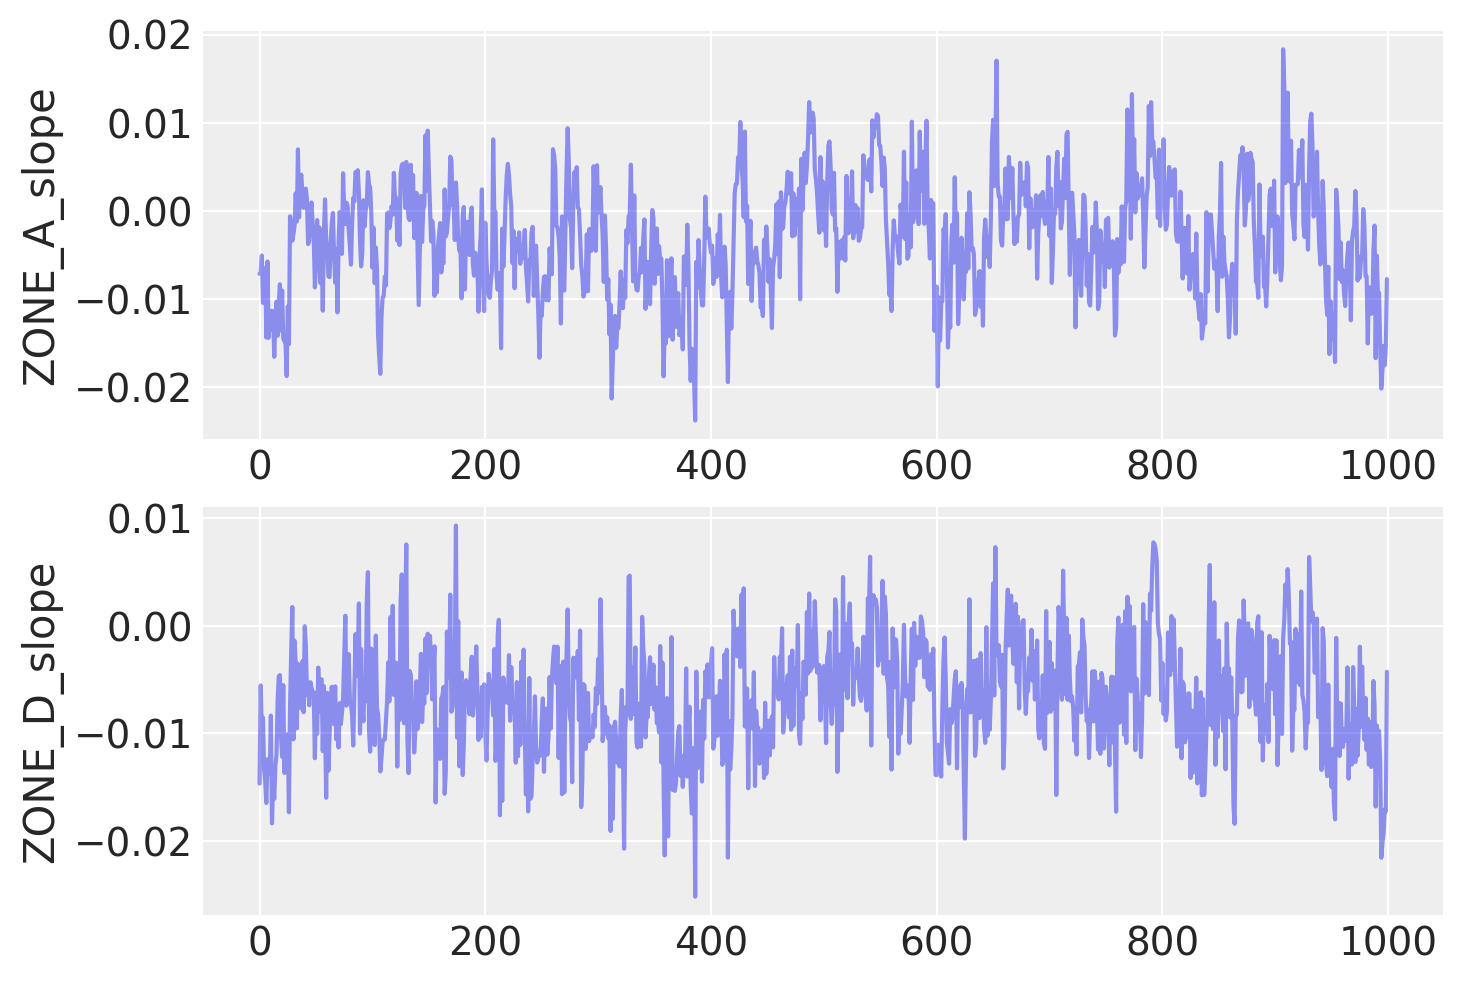

In [ ]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["ZONE_A_slope"], alpha=0.5)
axs[0].set(ylabel="ZONE_A_slope")
axs[1].plot(varying_intercept_slope_trace.posterior.sel(chain=0)["ZONE_D_slope"], alpha=0.5)
axs[1].set(ylabel="ZONE_D_slope");

In [ ]:
with varying_intercept_slope:
    pm.sample_posterior_predictive(varying_intercept_slope_trace, extend_inferencedata=True)

Output()

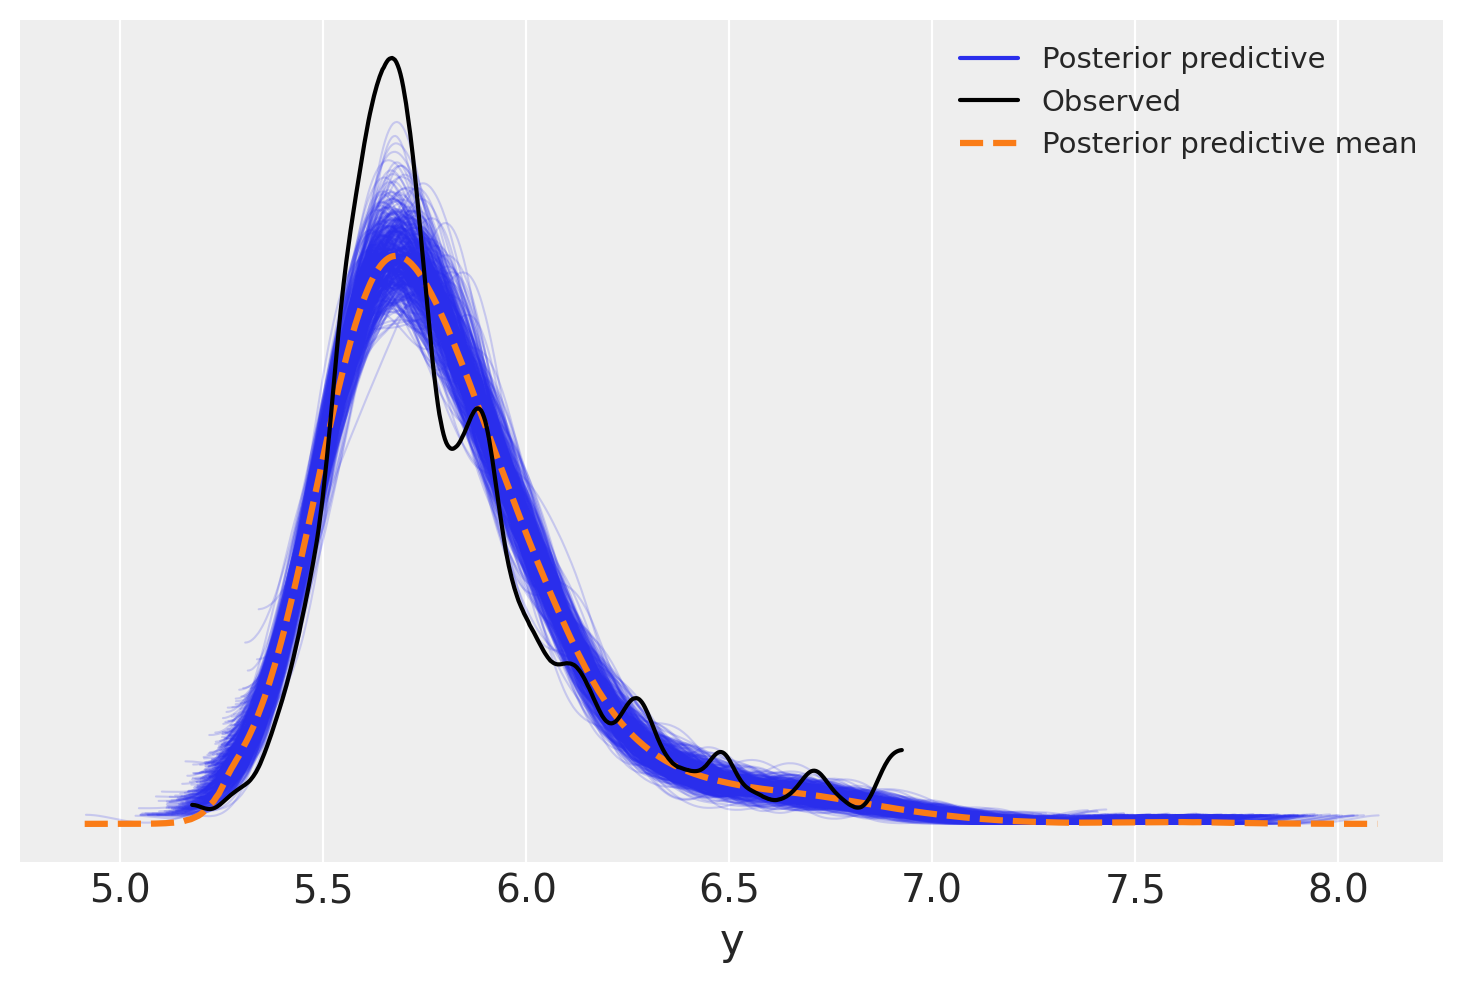

In [ ]:
az.plot_ppc(varying_intercept_slope_trace, num_pp_samples=500);